In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [7]:
symbols = trainSet.ticker.unique()

In [8]:
timesteps = 60
def make_samples(
    data_1,
    data_2,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps: i, 0]
        x_1 = x_1.reshape(-1,1)
        x_2 = x_1.reshape(-1,1)
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    sc.partial_fit(x_2)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['x_2'][j].append(sc.transform(x_2))
                    train_set[s]['y'][j].append(sc.transform(y))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [9]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
t = 1
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'x_2':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['x_2'][i] = []
        train_set[s]['y'][i] = []
        
    df = trainSet.loc[trainSet['ticker'] == s][['adj_close']]
    mv_rate = 20
    data_1 = df.values
    data_1 = data_1[mv_rate -1:]
    
    data_2 = df.rolling(mv_rate).mean().values
    data_2 = data_2[mv_rate-1:]
 
    make_samples(
        data_1,
        data_2,
        s)
    
    t += 1
    if t == 200:
        break

In [10]:
# Callback functions
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [11]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(2,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

# Training model

In [12]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
                train_set[s]['x_2'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(114474, 2, 60) (114474,)
Fitting prediction interval 1  model
Train on 80131 samples, validate on 34343 samples
Epoch 1/100
80131/80131 [==============================] - 3s 36us/step - loss: 0.1224 - val_loss: 0.0384
Epoch 2/100
80131/80131 [==============================] - 0s 4us/step - loss: 0.0773 - val_loss: 0.0315
Epoch 3/100
80131/80131 [==============================] - 0s 3us/step - loss: 0.0574 - val_loss: 0.0302
Epoch 4/100
80131/80131 [==============================] - 0s 3us/step - loss: 0.0465 - val_loss: 0.0285
Epoch 5/100
80131/80131 [==============================] - 0s 3us/step - loss: 0.0413 - val_loss: 0.0278
Epoch 6/100
80131/80131 [==============================] - 0s 3us/step - loss: 0.0383 - val_loss: 0.0252
Epoch 7/100
80131/80131 [==============================] - 0s 3us/step - loss: 0.0359 - val_loss: 0.0249
Epoch 8/100
80131/80131 [==============================] - 0s 3us/step - loss: 0.0344 - val_loss: 0.0228
Epoch 9/100
80131/80131 [=====================

79585/79585 [==============================] - 0s 3us/step - loss: 0.0568 - val_loss: 0.0469
Epoch 16/100
79585/79585 [==============================] - 0s 3us/step - loss: 0.0570 - val_loss: 0.0485
Epoch 17/100
79585/79585 [==============================] - 0s 3us/step - loss: 0.0560 - val_loss: 0.0476
Epoch 18/100
79585/79585 [==============================] - 0s 3us/step - loss: 0.0557 - val_loss: 0.0484
Epoch 19/100
79585/79585 [==============================] - 0s 3us/step - loss: 0.0542 - val_loss: 0.0522
Epoch 20/100
79585/79585 [==============================] - 0s 3us/step - loss: 0.0544 - val_loss: 0.0488
(112725, 2, 60) (112725,)
Fitting prediction interval 10  model
Train on 78907 samples, validate on 33818 samples
Epoch 1/100
78907/78907 [==============================] - 1s 12us/step - loss: 0.4209 - val_loss: 0.1230
Epoch 2/100
78907/78907 [==============================] - 0s 3us/step - loss: 0.1671 - val_loss: 0.1055
Epoch 3/100
78907/78907 [===========================

## Loss Graph

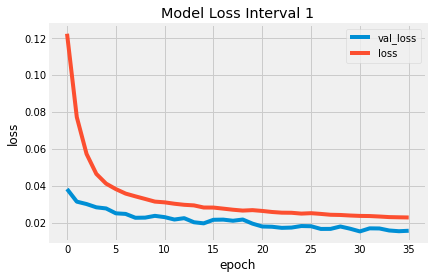

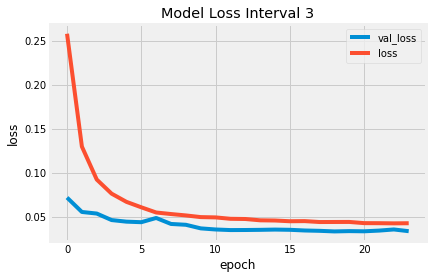

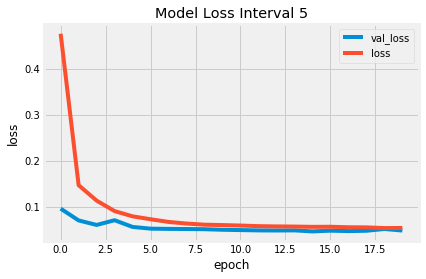

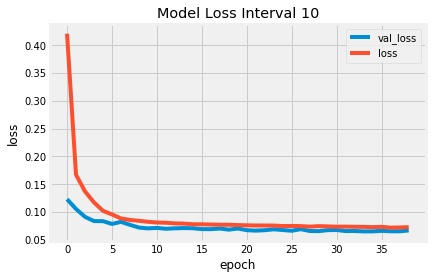

In [13]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

In [14]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [15]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Predicting with Test Set

In [16]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'x_2':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['x_2'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    df = testSet.loc[testSet['ticker'] == s][['adj_close']]
    mv_rate = 20
    data_1 = df.values
    data_1 = data_1[mv_rate -1:]
    
    data_2 = df.rolling(mv_rate).mean().values
    data_2 = data_2[mv_rate-1:]
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)

                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(x_2)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['x_2'][j].append(sc.transform(x_2))
                    test_set[s]['y'][j].append(y)
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [17]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
                data[s]['x_2'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

## Predict test sample

In [18]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 37.45945760044055
Test Set -> MSE of AAPL inveral 3: 47.54873197600708
Test Set -> MSE of AAPL inveral 5: 72.20832117834988
Test Set -> MSE of AAPL inveral 10: 86.6627658538857


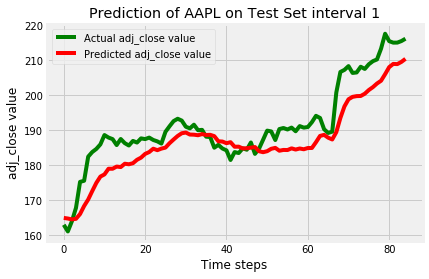

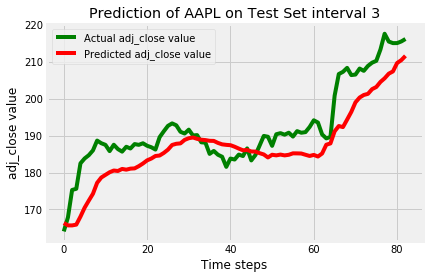

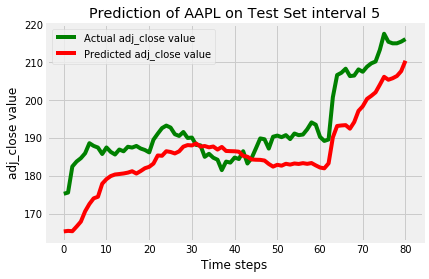

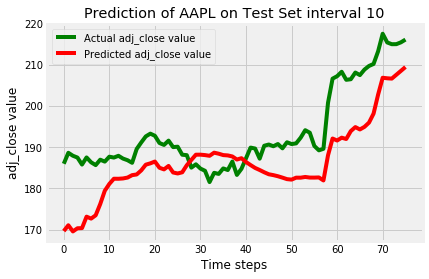

In [20]:
for i in prediction_intervals:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 10 symbols

In [21]:
test_symbols = ['A', 'ACER', 'MSFT', 'ABC', 'AAPL']

In [31]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [32]:
all_mse_1 = []
all_mse_3 = []
all_mse_5 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 2))
    all_mse_3.append(round(all_mse[s][3], 2))
    all_mse_5.append(round(all_mse[s][5], 2))
    all_mse_10.append(round(all_mse[s][10], 2))

In [35]:
all_mse_1

[1.85, 4.08, 4.4, 7.33, 37.46]

In [33]:
all_mse_3

[2.83, 4.54, 5.09, 10.42, 47.55]

In [34]:
all_mse_5

[3.3, 5.92, 7.77, 13.39, 72.21]

In [36]:
all_mse_10

[3.46, 5.13, 9.71, 19.77, 86.66]